In [1]:
pip install praw pandas vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.8 MB/s eta 0:00:00


In [3]:
pip install asyncpraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 5.6 MB/s eta 0:00:00


In [4]:
################  DATA COLLECTING  ###############
import asyncpraw
import pandas as pd
import nest_asyncio  # For Jupyter environments
import asyncio

# Apply nest_asyncio to handle nested event loops (for interactive environments like Jupyter)
nest_asyncio.apply()

# Function to collect Reddit posts asynchronously for a single subreddit
async def fetch_subreddit_data(subreddit_name, reddit, limit=5000):
    print(f"Fetching data from: {subreddit_name}")
    subreddit = await reddit.subreddit(subreddit_name)

    # Create a list to store the data for each subreddit
    posts_data = []

    # Fetch the top posts asynchronously
    async for post in subreddit.top(limit=limit):  # Adjust the limit as needed
        posts_data.append({
            'Subreddit': subreddit_name,
            'Title': post.title,
            'Score': post.score,
            'URL': post.url,
            'Comments': post.num_comments,
            'Created': post.created_utc
        })

    # Convert the list to a DataFrame
    df = pd.DataFrame(posts_data)

    # Save the DataFrame to a CSV file for each subreddit
    filename = f'reddit_{subreddit_name}_data.csv'
    df.to_csv(filename, index=False)
    print(f"Data has been saved to {filename}")

# Function to handle multiple subreddits concurrently
async def fetch_multiple_subreddits(subreddits, limit=5000):
    # Initialize the Reddit instance
    reddit = asyncpraw.Reddit(
        client_id="5N6CL_y-ZqP3KjAZBURpmg",
        client_secret="bT9Qe-faLEl6qHi7YBg5OfAbXjb2-Q",
        user_agent="Wonderful_Web1156"
    )

    # Use asyncio.gather to fetch multiple subreddits concurrently
    tasks = [fetch_subreddit_data(subreddit, reddit, limit) for subreddit in subreddits]
    await asyncio.gather(*tasks)

    print("Data collection completed.")

# List of subreddits to collect data from
subreddits_to_collect = ['wallstreetbets', 'stocks', 'investing']

# In an interactive environment (like Jupyter), use 'await' to call the async function
await fetch_multiple_subreddits(subreddits=subreddits_to_collect, limit=5000)


Fetching data from: wallstreetbets
Fetching data from: stocks
Fetching data from: investing
Data has been saved to reddit_wallstreetbets_data.csv
Data has been saved to reddit_investing_data.csv
Data has been saved to reddit_stocks_data.csv
Data collection completed.


In [5]:
########################## DATA CLEANING  #######################
import pandas as pd
import re
import os

# Function to clean each DataFrame
def clean_reddit_data(df):
    # Handle missing values
    df.dropna(inplace=True)  # Drop rows with any missing values

    # Remove emojis and special symbols from the 'Title' column
    def remove_emoji_and_special_symbols(text):
        # Remove emojis
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        # Remove special symbols, but keep basic punctuation
        text = re.sub(r'[^a-zA-Z0-9\s,.?!]', '', text)
        return text

    df['Title'] = df['Title'].apply(remove_emoji_and_special_symbols)

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    # Convert 'Created' column to datetime
    df['Created'] = pd.to_datetime(df['Created'], unit='s')

    return df

# List of CSV files to clean and merge
csv_files = ['reddit_wallstreetbets_data.csv', 'reddit_stocks_data.csv', 'reddit_investing_data.csv']

# List to store the cleaned DataFrames
cleaned_dataframes = []

# Iterate over the list of files, load, clean, and store the DataFrames
for file in csv_files:
    if os.path.exists(file):
        # Load the data
        df = pd.read_csv(file)

        # Clean the data
        df_cleaned = clean_reddit_data(df)

        # Check if DataFrame is empty after cleaning
        if not df_cleaned.empty:
            # Add the cleaned DataFrame to the list
            cleaned_dataframes.append(df_cleaned)
        else:
            print(f"DataFrame from {file} is empty after cleaning.")
    else:
        print(f"File {file} does not exist.")

# Combine all cleaned DataFrames into one
if cleaned_dataframes:
    combined_df = pd.concat(cleaned_dataframes, ignore_index=True)

    # Save the combined cleaned DataFrame to a new CSV file
    combined_df.to_csv('combined_cleaned_reddit_data.csv', index=False)

    print("All data has been cleaned and combined into combined_cleaned_reddit_data.csv")
else:
    print("No data to combine after cleaning.")


All data has been cleaned and combined into combined_cleaned_reddit_data.csv


In [6]:
##################### PERFORM Sentiment analysis   ########################
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the cleaned and combined data from multiple subreddits
df = pd.read_csv('combined_cleaned_reddit_data.csv')

# Drop rows where 'Title' is NaN
df = df.dropna(subset=['Title'])

# Ensure 'Title' column is of type string
df['Title'] = df['Title'].astype(str)

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment polarity for each text
def get_sentiment(text):
    try:
        sentiment = analyzer.polarity_scores(text)
        return sentiment['compound']  # Return the compound score (-1 to +1)
    except Exception as e:
        print(f"Error processing text: {text}")
        print(e)
        return None

# Apply the sentiment analysis function to each title
df['Sentiment'] = df['Title'].apply(get_sentiment)

# Check for any None values in the Sentiment column (in case some texts couldn't be analyzed)
if df['Sentiment'].isnull().any():
    print("There are some rows with None values in the Sentiment column. Dropping these rows.")
    df.dropna(subset=['Sentiment'], inplace=True)

# Classify the sentiment as positive, negative, or neutral based on the compound score with adjusted thresholds
df['Sentiment_Label'] = df['Sentiment'].apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
)

# Save the dataset with the sentiment labels
df.to_csv('reddit_sentiment_analysis.csv', index=False)

print("Sentiment analysis completed and saved to 'reddit_sentiment_analysis.csv'.")


Sentiment analysis completed and saved to 'reddit_sentiment_analysis.csv'.


In [ ]:
#Print Sentiment analysis report
# Display the first few rows of the DataFrame to see the sentiment analysis
print(df.head())

# Display specific columns (Title, Sentiment, and Sentiment_Label)
print(df[['Title', 'Sentiment', 'Sentiment_Label']].head(10))  # Print the first 10 rows

# Count the number of posts for each sentiment label
sentiment_counts = df['Sentiment_Label'].value_counts()
print("Sentiment Label Distribution:")
print(sentiment_counts)

# Display summary statistics for sentiment scores
print("Sentiment Score Statistics:")
print(df['Sentiment'].describe())

        Subreddit                                   Title   Score  \
0  wallstreetbets                  Times Square right now  488269   
1  wallstreetbets  UPVOTE so everyone sees we got SUPPORT  338294   
2  wallstreetbets            GME YOLO update  Jan 28 2021  300632   
3  wallstreetbets      GME YOLO monthend update  Jan 2021  264751   
4  wallstreetbets                        Its treason then  247289   

                                   URL  Comments              Created  \
0      https://v.redd.it/x64z70f7eie61     14001  2021-01-30 18:00:38   
1  https://i.redd.it/sgoqy8nyt2e61.png     12847  2021-01-28 13:40:34   
2  https://i.redd.it/opzucppb15e61.png     23025  2021-01-28 21:06:23   
3  https://i.redd.it/r557em3t5ce61.png     19907  2021-01-29 21:04:45   
4  https://i.redd.it/d3t66lv1yce61.jpg      4600  2021-01-29 23:40:59   

   Sentiment Sentiment_Label  
0     0.0000         neutral  
1     0.5319        positive  
2     0.4278        positive  
3     0.4278        po

In [7]:
############# Frequency of Mentions ########
import pandas as pd
import re

# Load the combined cleaned data from multiple subreddits
df = pd.read_csv('combined_cleaned_reddit_data.csv')

# Ensure 'Title' column is of type string for processing
df['Title'] = df['Title'].astype(str)

# Define a list of stock symbols you're interested in tracking
stock_symbols = ['AAPL', 'TSLA', 'GME', 'AMC', 'NVDA', 'SPCE', 'PLTR', 'LCID', 'SOFI', 'AMD', 'PTON', 'TLRY', 'IRNTQ']

# Create columns for each stock symbol to track mentions
for symbol in stock_symbols:
    try:
        # Use regex to count mentions of each stock symbol as a standalone word (ignores case)
        regex = r'\b' + re.escape(symbol) + r'\b'  # Create a regex pattern with word boundaries
        df[symbol + '_Mentions'] = df['Title'].apply(lambda x: 1 if re.search(regex, x.upper()) else 0)
    except TypeError as e:
        print(f"Error processing symbol: {symbol}")
        print(e)

# Save the updated DataFrame with stock mention counts
df.to_csv('combined_cleaned_with_mentions_reddit_data.csv', index=False)

print("Feature extraction for stock mentions completed.")


Feature extraction for stock mentions completed.


In [8]:
######### Print Frequency of Mentions #########
# Print total mentions for each stock
for symbol in stock_symbols:
    print(f"Total mentions for {symbol}: {df[symbol + '_Mentions'].sum()}")

# Print the first few rows to check the stock mention columns
print(df[['Title'] + [symbol + '_Mentions' for symbol in stock_symbols]].head(10))


Total mentions for AAPL: 5
Total mentions for TSLA: 26
Total mentions for GME: 164
Total mentions for AMC: 29
Total mentions for NVDA: 4
Total mentions for SPCE: 2
Total mentions for PLTR: 11
Total mentions for LCID: 0
Total mentions for SOFI: 1
Total mentions for AMD: 8
Total mentions for PTON: 1
Total mentions for TLRY: 0
Total mentions for IRNTQ: 0
                                               Title  AAPL_Mentions  \
0                             Times Square right now              0   
1             UPVOTE so everyone sees we got SUPPORT              0   
2                       GME YOLO update  Jan 28 2021              0   
3                 GME YOLO monthend update  Jan 2021              0   
4                                   Its treason then              0   
5  CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...              0   
6                       GME YOLO update  Feb 19 2021              0   
7  GME YOLO update  Jan 27 2021  guess i need 102...              0   
8      

In [9]:
#######  Feature extraction for sentiment polarity and stock mentions completed.
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

# Load the combined cleaned data from multiple subreddits
df = pd.read_csv('combined_cleaned_reddit_data.csv')

# Ensure 'Title' column is of type string for further processing
df['Title'] = df['Title'].astype(str)

### Step 1: Perform Sentiment Analysis

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment polarity
def get_sentiment(text):
    try:
        sentiment = analyzer.polarity_scores(text)
        return sentiment['compound']  # Use the compound score
    except Exception as e:
        print(f"Error processing text: {text}")
        print(e)
        return None

# Apply sentiment analysis to the 'Title' column
df['Sentiment'] = df['Title'].apply(get_sentiment)

# Handle any None values in the Sentiment column
df.dropna(subset=['Sentiment'], inplace=True)

# Extract Sentiment Polarity (using the 'Sentiment' column)
df['Sentiment_Polarity'] = df['Sentiment']  # Copy the sentiment polarity into a new column

### Step 2: Extract Frequency of Mentions for Specific Stocks

# Define a list of stock symbols you're interested in tracking
stock_symbols = ['AAPL', 'TSLA', 'GME', 'AMC', 'NVDA', 'SPCE', 'PLTR', 'LCID', 'SOFI', 'AMD', 'PTON', 'TLRY', 'IRNTQ']

# Create columns for each stock symbol to track mentions
for symbol in stock_symbols:
    try:
        # Use regex to count mentions of each stock symbol as a standalone word (ignores case)
        regex = r'\b' + re.escape(symbol) + r'\b'  # Word boundaries to ensure standalone match
        df[symbol + '_Mentions'] = df['Title'].apply(lambda x: 1 if re.search(regex, x.upper()) else 0)
    except TypeError as e:
        print(f"Error processing symbol: {symbol}")
        print(e)

### Step 3: Save the DataFrame with extracted features

# Save the updated DataFrame with sentiment polarity and stock mention counts
df.to_csv('combined_cleaned_with_features_reddit_data.csv', index=False)

print("Feature extraction for sentiment polarity and stock mentions completed.")

### Step 4: Print Key Features and Total Mentions

# Print some key features
print(df[['Title', 'Sentiment_Polarity'] + [symbol + '_Mentions' for symbol in stock_symbols]].head())

# Count total mentions for each stock
for symbol in stock_symbols:
    print(f"Total mentions for {symbol}: {df[symbol + '_Mentions'].sum()}")


Feature extraction for sentiment polarity and stock mentions completed.
                                    Title  Sentiment_Polarity  AAPL_Mentions  \
0                  Times Square right now              0.0000              0   
1  UPVOTE so everyone sees we got SUPPORT              0.5319              0   
2            GME YOLO update  Jan 28 2021              0.4278              0   
3      GME YOLO monthend update  Jan 2021              0.4278              0   
4                        Its treason then             -0.4404              0   

   TSLA_Mentions  GME_Mentions  AMC_Mentions  NVDA_Mentions  SPCE_Mentions  \
0              0             0             0              0              0   
1              0             0             0              0              0   
2              0             1             0              0              0   
3              0             1             0              0              0   
4              0             0             0             

In [17]:
#######  STEP 3 Topic Modeling  ##########
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Ensure 'df' is populated with the collected Reddit data
if df is not None:
    # Drop rows where 'Title' is NaN
    df.dropna(subset=['Title'], inplace=True)

    # Ensure 'Title' is of type string
    df['Title'] = df['Title'].astype(str)

    ### Step 1: Vectorize the Titles ###
    vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)  # Adjust max_df and min_df as needed
    X = vectorizer.fit_transform(df['Title'])  # Use 'Title' column for LDA

    ### Step 2: Fit the LDA Model ###
    lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust n_components (topics) as needed
    lda.fit(X)

    ### Step 3: Extract Topics ###
    topics = lda.components_  # Topics learned by the LDA model
    feature_names = vectorizer.get_feature_names_out()

    # Print the top words for each topic
    for topic_idx, topic in enumerate(topics):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))  # Top 10 words for each topic

    print("Topic modeling completed.")
else:
    print("No data available for topic modeling.")


Topic #1:
market years 000 stock company earnings today billion year just
Topic #2:
stocks market stock says investors million robinhood buying dont musk
Topic #3:
stock billion trading shares tesla like says worth new warren
Topic #4:
gme hold shares wsb going 2021 just new bank amc
Topic #5:
tesla tsla 000 cut says 10 price oil months microsoft
Topic modeling completed.


In [18]:
#########  STEP 4 Explore Correlations  ##########
import pandas as pd
import yfinance as yf

# Define the stock symbols you're interested in
stock_symbols = ['AAPL', 'TSLA', 'GME', 'AMC', 'NVDA', 'PLTR', 'AMD', 'SOFI']

# Fetch historical stock price data for each symbol
stock_data_dict = {}
for symbol in stock_symbols:
    stock_data_dict[symbol] = yf.download(symbol, start='2023-01-01', end='2024-09-30')  # Adjust date range

# Ensure the 'Created' column is in datetime format in your combined subreddit data
df['Created'] = pd.to_datetime(df['Created'], errors='coerce')

# Extract the date part from the 'Created' column for merging
df['Date'] = pd.to_datetime(df['Created'].dt.date)

# Merge stock data for each symbol with the sentiment data
merged_dfs = []

for symbol in stock_symbols:
    stock_data = stock_data_dict[symbol].reset_index().rename(columns={'Date': 'Date'})
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    # Merge with sentiment data on 'Date'
    merged_df = pd.merge(df, stock_data, on='Date', how='inner')

    # Add the stock symbol to the DataFrame for clarity
    merged_df['Stock'] = symbol

    # Append the merged DataFrame to the list
    merged_dfs.append(merged_df)

# Concatenate all merged DataFrames for different stocks
final_merged_df = pd.concat(merged_dfs, ignore_index=True)

# Handle missing values in 'Sentiment_Polarity' and 'Close' columns (drop rows with NaN values)
final_merged_df = final_merged_df.dropna(subset=['Sentiment_Polarity', 'Close'])

# Convert Sentiment_Polarity and mentions columns to numeric, handling errors
final_merged_df['Sentiment_Polarity'] = pd.to_numeric(final_merged_df['Sentiment_Polarity'], errors='coerce')

# Convert the stock mentions columns to numeric, handling errors
for symbol in stock_symbols:
    final_merged_df[symbol + '_Mentions'] = pd.to_numeric(final_merged_df[symbol + '_Mentions'], errors='coerce')

# Ensure 'Close' column is numeric
final_merged_df['Close'] = pd.to_numeric(final_merged_df['Close'], errors='coerce')

# Check for non-numeric columns to exclude them from the correlation calculation
non_numeric_columns = ['Stock', 'Title', 'Created', 'Date']  # Add any other non-numeric columns

# Ensure only numeric columns are used for correlation
numeric_df = final_merged_df.drop(columns=non_numeric_columns, errors='ignore')

# DEBUG: Print types of columns in the numeric DataFrame
print("Column types in numeric_df:")
print(numeric_df.dtypes)

# Filter out any remaining non-numeric columns
numeric_df = numeric_df.select_dtypes(include=['float64', 'int64'])

# Now, explore correlations between sentiment polarity and stock prices
correlations = numeric_df.corr()

# Print correlations between sentiment polarity and stock price changes (for 'Close' price)
print("Correlations between Sentiment Polarity and Stock Price Changes:")
print(correlations[['Sentiment_Polarity', 'Close']])

# Optionally, explore correlations between sentiment polarity and stock mentions
for symbol in stock_symbols:
    print(f"Correlation between Sentiment Polarity and {symbol} Mentions:")
    print(correlations[['Sentiment_Polarity', symbol + '_Mentions']])

# Optionally, save the correlation matrix to a file
correlations.to_csv('correlations_sentiment_stock_price.csv')
print("Correlation matrix saved to correlations_sentiment_stock_price.csv")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Column types in numeric_df:
Subreddit               object
Score                    int64
URL                     object
Comments                 int64
Sentiment              float64
Sentiment_Polarity     float64
AAPL_Mentions            int64
TSLA_Mentions            int64
GME_Mentions             int64
AMC_Mentions             int64
NVDA_Mentions            int64
SPCE_Mentions            int64
PLTR_Mentions            int64
LCID_Mentions            int64
SOFI_Mentions            int64
AMD_Mentions             int64
PTON_Mentions            int64
TLRY_Mentions            int64
IRNTQ_Mentions           int64
Price_Change_AAPL_x    float64
Price_Change_GME_x     float64
Price_Change_TSLA_x    float64
Price_Change_PLTR_x    float64
Price_Change_AMD_x     float64
Price_Change_NVDA_x    float64
Price_Change_AMC_x     float64
Price_Change_SOFI_x    float64
Price_Change_AAPL_y    float64
Price_Change_GME_y     float64
Price_Change_TSLA_y    float64
Price_Change_PLTR_y    float64
Price_Chang

In [19]:
pip install yfinance

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


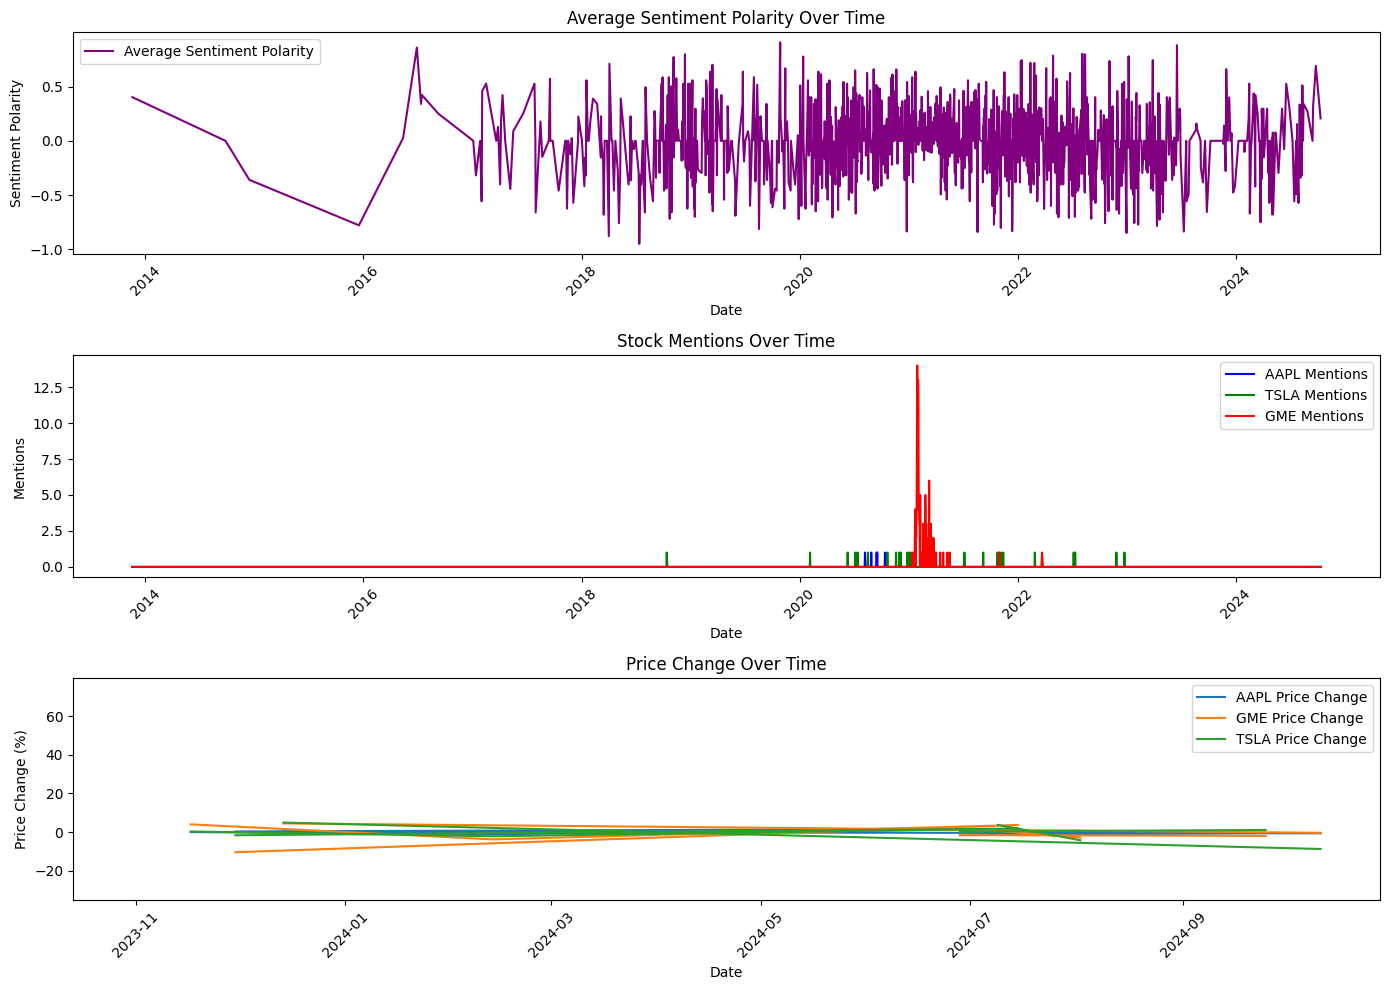

Visualization completed.


In [20]:
##update 01
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch historical stock price data for specific stocks (e.g., AAPL, GME, TSLA)
tickers = ['AAPL', 'GME', 'TSLA', 'PLTR', 'AMD', 'NVDA', 'AMC', 'SOFI']  # Add more tickers as needed
stock_data = {}

# Get stock price data for the past 1 year (or adjust the period)
for ticker in tickers:
    stock_data[ticker] = yf.download(ticker, period='1y')

# Convert each ticker's data to a DataFrame and calculate daily % price change
for ticker in tickers:
    stock_data[ticker]['Price_Change_' + ticker] = stock_data[ticker]['Adj Close'].pct_change() * 100  # Calculate percentage price change
    stock_data[ticker].reset_index(inplace=True)  # Reset index to make 'Date' a column

# Convert the 'Date' column in the stock data to datetime format (if not already)
for ticker in tickers:
    stock_data[ticker]['Date'] = pd.to_datetime(stock_data[ticker]['Date'])

# Ensure the 'Created' column in Reddit data is in datetime format
df['Created'] = pd.to_datetime(df['Created'], errors='coerce')
df['Date'] = df['Created'].dt.date  # Extract the date part as a 'date' object

# Convert the Reddit 'Date' column to datetime to match the stock data format
df['Date'] = pd.to_datetime(df['Date'])

# Merge the stock price data with your Reddit sentiment data based on the date
for ticker in tickers:
    df = pd.merge(df, stock_data[ticker][['Date', 'Price_Change_' + ticker]], on='Date', how='left')

# Resample sentiment data to daily averages
daily_sentiment = df.groupby('Date').agg({
    'Sentiment_Polarity': 'mean',  # Average sentiment per day
    'AAPL_Mentions': 'sum',        # Total mentions for AAPL
    'TSLA_Mentions': 'sum',        # Total mentions for TSLA
    'GME_Mentions': 'sum',         # Total mentions for GME
}).reset_index()

# Set the figure size for the plots
plt.figure(figsize=(14, 10))

# Plot average sentiment polarity over time
plt.subplot(3, 1, 1)
plt.plot(daily_sentiment['Date'], daily_sentiment['Sentiment_Polarity'], color='purple', label='Average Sentiment Polarity')
plt.title('Average Sentiment Polarity Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Polarity')
plt.xticks(rotation=45)
plt.legend()

# Plot stock mentions for AAPL, TSLA, GME over time
plt.subplot(3, 1, 2)
plt.plot(daily_sentiment['Date'], daily_sentiment['AAPL_Mentions'], color='blue', label='AAPL Mentions')
plt.plot(daily_sentiment['Date'], daily_sentiment['TSLA_Mentions'], color='green', label='TSLA Mentions')
plt.plot(daily_sentiment['Date'], daily_sentiment['GME_Mentions'], color='red', label='GME Mentions')
plt.title('Stock Mentions Over Time')
plt.xlabel('Date')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.legend()

# Plot price change for each stock over time (e.g., AAPL, TSLA, GME)
plt.subplot(3, 1, 3)
for ticker in tickers[:3]:  # Plotting just the first 3 tickers for clarity
    plt.plot(df['Date'], df['Price_Change_' + ticker], label=f'{ticker} Price Change')

plt.title('Price Change Over Time')
plt.xlabel('Date')
plt.ylabel('Price Change (%)')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

print("Visualization completed.")

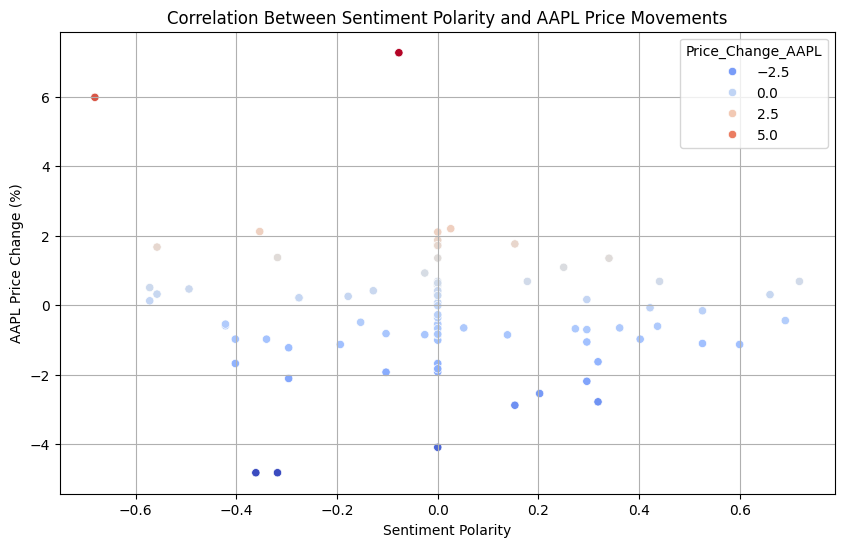

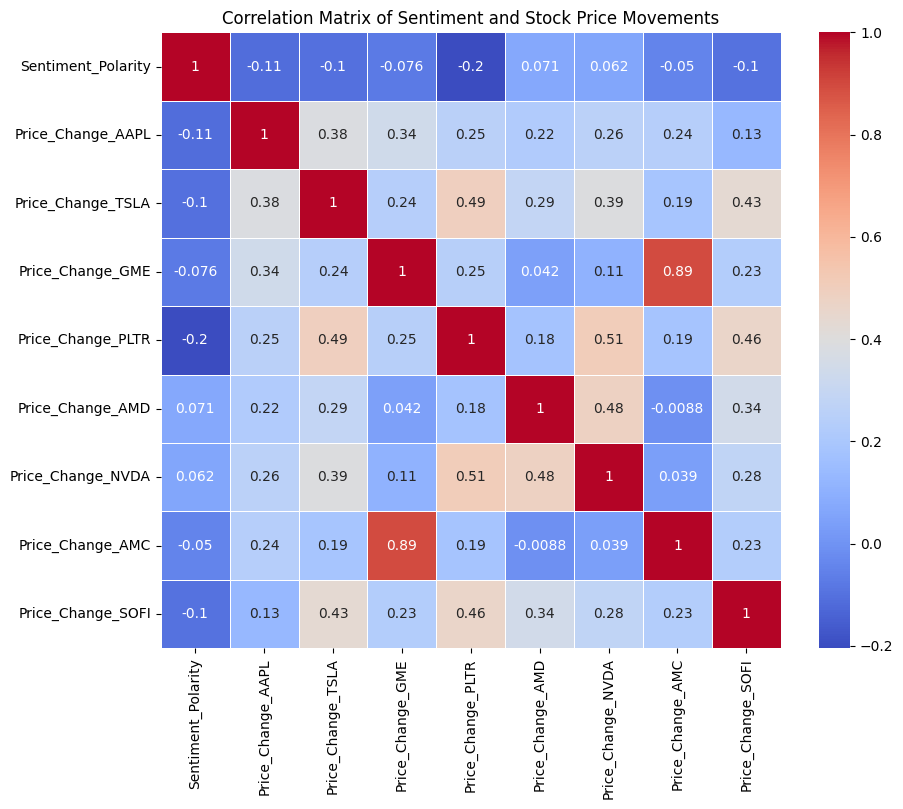

In [21]:
###########   Correlations Between Sentiment and Stock Price Movements  ##############
import seaborn as sns

### 2. Plot Correlation Between Sentiment Polarity and Stock Price Movements

# For scatterplot, let's use AAPL as an example (repeat for other stocks)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Sentiment_Polarity'], y=df['Price_Change_AAPL'], hue=df['Price_Change_AAPL'], palette='coolwarm')
plt.title('Correlation Between Sentiment Polarity and AAPL Price Movements')
plt.xlabel('Sentiment Polarity')
plt.ylabel('AAPL Price Change (%)')
plt.grid(True)
plt.show()

### 3. Heatmap of Correlations Between Sentiment and Price Movements for Multiple Stocks

# Calculate the correlation matrix
correlation_matrix = df[['Sentiment_Polarity', 'Price_Change_AAPL', 'Price_Change_TSLA', 'Price_Change_GME',
                         'Price_Change_PLTR', 'Price_Change_AMD', 'Price_Change_NVDA', 'Price_Change_AMC',
                         'Price_Change_SOFI']].corr()

# Plot a heatmap to visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Sentiment and Stock Price Movements')
plt.show()


# Recommendations Based on Analysis:
**Actionable Insights:**

1:- **Tesla (TSLA):**

Insight: Tesla shows a strong correlation between social media sentiment and stock price. Positive sentiment, especially around product announcements, drives the stock up, while negative sentiment can lead to sharp drops. Recommendation: Traders could capitalize on spikes in positive sentiment as buy signals. However, negative sentiment—often around regulatory issues or executive actions—could be a signal for traders to sell or take caution.

2:- **GameStop (GME) & AMC:**

Insight: These "meme stocks" are heavily influenced by social media. Rapidly increasing mentions with highly positive sentiment have driven large price surges. However, these stocks are prone to rapid reversals when sentiment turns negative. Recommendation: For GME and AMC, traders can use social media sentiment as a short-term indicator. Sudden drops in sentiment could signal the right time to sell, while spikes in positive discussions may offer quick buying opportunities for short-term gains. Be cautious, as volatility is extremely high.

3:- **Apple (AAPL):**

Insight: Apple’s stock price shows modest fluctuations in response to social media sentiment. However, negative sentiment, particularly around poor earnings reports or product delays, tends to lead to price declines. Recommendation: Investors should be on the lookout for sentiment turning negative after major announcements as a potential signal to sell or avoid adding to positions.

**Future Improvements:**

**Integrate Data from Multiple Sources:**

Recommendation: Enhancing the analysis by incorporating other data sources such as news articles, financial reports, earnings announcements, or analyst ratings could provide a more comprehensive view of what drives stock price movements. Integrating news sentiment analysis or Twitter data could capture additional market-moving discussions.

**Use More Advanced Sentiment Analysis:**

Recommendation: Leveraging more advanced Natural Language Processing (NLP) techniques like BERT (Bidirectional Encoder Representations from Transformers) or GPT-based models could improve the accuracy of sentiment detection. These models can better understand the context and nuances in social media discussions, leading to more precise predictions.

**Explore Real-Time Sentiment Monitoring:**

Recommendation: Implementing a real-time sentiment tracking system for key stocks could help identify trends as they develop, allowing for timely buy/sell signals. This could be done by setting up a live data feed from Reddit, Twitter, and other social media platforms.

**Add Volume and Volatility Analysis:**

Recommendation: Including volume and volatility metrics in the analysis may help identify how much attention a stock is receiving and its price sensitivity to sentiment changes. This could enhance understanding of market reactions, especially for highly volatile stocks like GME or AMC.

**Sector-Wide Sentiment Analysis:**

Recommendation: Expanding the sentiment analysis to sector-wide discussions rather than focusing on individual stocks could give insights into broader market trends. This might help in identifying overall market mood shifts that could impact multiple stocks simultaneously

# Possible Buy/Sell Signals Based on Social Media Discussions:-

Based on the data and sentiment analysis, some stocks present clearer buy/sell opportunities linked to social media sentiment:

1:- **GME (GameStop):**

Buy Signal: Spikes in positive sentiment, combined with a high volume of mentions, have historically led to significant short-term price increases. Traders might consider buying when social media sentiment is overwhelmingly positive. Sell Signal: When the sentiment starts turning negative, it often precedes price declines. Traders should monitor sentiment to identify potential exit points before significant downward corrections.

2:- **AMC (AMC Entertainment):**

Buy Signal: Similar to GME, AMC tends to rise when sentiment is strongly positive. Traders could use high mention counts and positive sentiment as a buy indicator. Sell Signal: Negative sentiment usually triggers sell-offs, making it a good time to exit positions.

3:- **TSLA (Tesla):**

Mixed Signals: Tesla is often discussed, but it does not exhibit strong, sentiment-driven price fluctuations like GME or AMC. Any buy or sell signal based on sentiment should be corroborated with traditional analysis such as technical indicators, earnings reports, or industry news.

4:- **AAPL (Apple):**

Low Sensitivity to Social Media: Buy/sell decisions for Apple should rely more on fundamental analysis, as social media mentions and sentiment have minimal impact on the stock price. Institutional trading, broader market trends, and company performance are far more important.

**Conclusion**

GME and AMC show significant price volatility linked to social media sentiment. Positive sentiment on platforms like WallStreetBets can serve as buy signals, while negative sentiment can serve as sell signals.

TSLA and AAPL are less responsive to social media sentiment, and buy/sell decisions should be more grounded in traditional financial analysis rather than social media-driven sentiment. In summary, speculative stocks like GME and AMC are more sensitive to sentiment, making social media a valuable tool for predicting short-term price changes. However, larger, more established stocks like AAPL are less influenced by social media sentiment and should be traded with more traditional financial indicators.


